#Import libraries and pip installs

In [48]:
!pip install statsforecast

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [50]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [51]:
import scipy.stats as stats

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [53]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

#Import data

In [54]:
df = pd.read_csv('https://raw.githubusercontent.com/SigneByrith/Projekt/main/TSLA.csv')

In [55]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000
1,2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000
2,2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000
3,2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000
4,2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2518 non-null   object 
 1   Open       2518 non-null   float64
 2   High       2518 non-null   float64
 3   Low        2518 non-null   float64
 4   Close      2518 non-null   float64
 5   Adj Close  2518 non-null   float64
 6   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


#Creation of the dataframe

In the following section we want to transform the dataframe into one that can be used in the StatsForecast made by the Nixtla team

We will now create the inputs for the StatsForecast. We will need a unique_id, which is identifier for the specific time series, a "ds" which is the time series we will be working within, and "y" which is the values we wish to work with

In [57]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2013-01-02,2.357333
1,2013-01-03,2.318000
2,2013-01-04,2.293333
3,2013-01-07,2.289333
4,2013-01-08,2.245333
...,...,...
2513,2022-12-23,123.150002
2514,2022-12-27,109.099998
2515,2022-12-28,112.709999
2516,2022-12-29,121.820000


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2518 non-null   object 
 1   Close   2518 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


In [59]:
df["unique_id"]="1"
df.columns=["ds","y","unique_id"]
df.head()

,ds,y,unique_id
0,2013-01-02,2.357333,1
1,2013-01-03,2.318000,1
2,2013-01-04,2.293333,1
3,2013-01-07,2.289333,1
4,2013-01-08,2.245333,1


Another requirement for the "ds" feature is that it is necessary to be a dtype datatime or an integer

In [60]:
df.dtypes

ds            object
y            float64
unique_id     object
dtype: object

In [61]:
df["ds"] = pd.to_datetime(df["ds"])

We will now plot the dataframe we will be working with

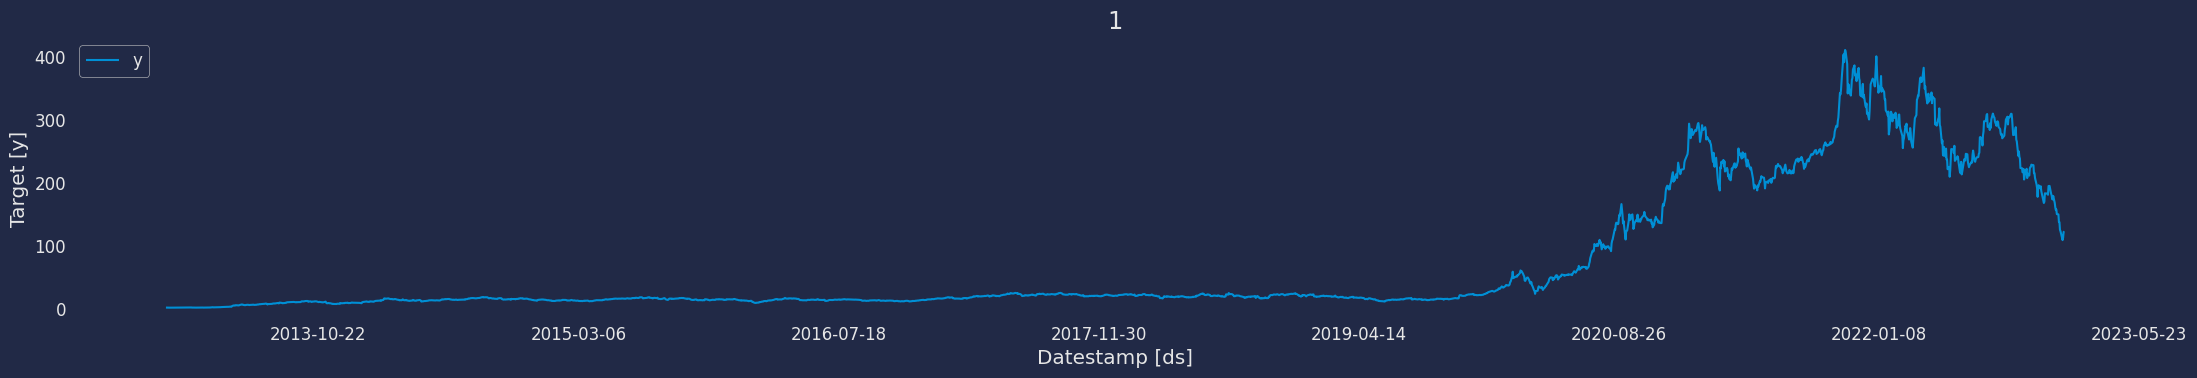

In [62]:
StatsForecast.plot(df, engine="matplotlib")

#Split the data

We will now split the data into a train and test data set. The first to train the AutoArima and the other to test the model

In [63]:
Y_train_df = df[df.ds<df['ds'].values[-12]] # 132 train
Y_test_df = df[df.ds>=df['ds'].values[-12]].reset_index(drop=True) # 12 test

We now show how the shape of the split

In [64]:
Y_train_df.shape, Y_test_df.shape

((2506, 3), (12, 3))

We now visualize the test and train set

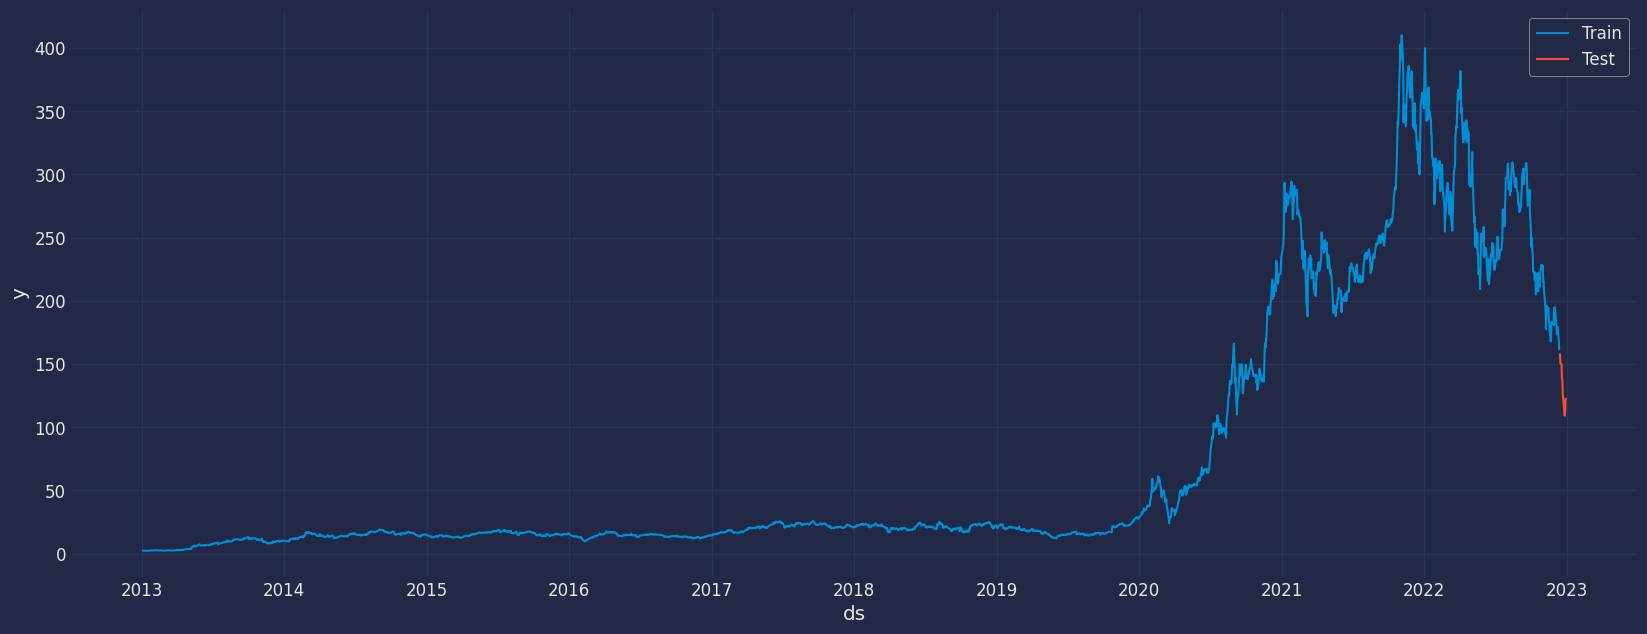

In [65]:
sns.lineplot(Y_train_df,x="ds", y="y", label="Train")
sns.lineplot(Y_test_df, x="ds", y="y", label="Test")
plt.show()

#Setting up the model

Firstly, we import the features form the Statsforecast

In [66]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In this section we initiates the model

Firstly we need to define the enteties that we need as the season_length is the sesonalinal periods, and horizon is the lenengt of our test data. These to arguments are then put into the AutoArima

In [67]:
season_length = 0 # Monthly data
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]

In the following code we fit the model using StatsForecat where the arguemnt is the train split of the data as the dataframe, the model is insertet using the "models=models", the freq is the frequentcy of the data, and given we are working with stocks, it needs to be set to "B" mening business days, and the n_jobs the the number of jobs used in the parallel processing, where the number "-1" is recommemed.

In [68]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='B',
                   n_jobs=-1)

In [69]:
sf.fit()

StatsForecast(models=[AutoARIMA])

We now no the best model found, and can see that acording to the code, that we have a P=0, meaning is has 0 non-seasonal autoregressive element, it has one seasonal differential adn q=1 which is the mocing average element

In [70]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,1,0)                   '

to better know the values of the model be use the following code:

In [71]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 0, 0, 1, 1, 0)


#Forecast method

In the follwoing section we utilize the StatsForecast.forecast function instead of the normal "fit" and "predict". The mean difference is that when using the .forecast the model di nit store the fitted valus and is scalable.

To perform forecast using this function we will need the the forecast horizon, h and and level, hvish is a feature using probalisatic forecast. This feature means that it the confidence intervall of the forecast can be decided:

We initialize the model with the following:

In [72]:
Y_hat_df = sf.forecast(horizon, fitted=True)

Y_hat_df.head()

,ds,AutoARIMA
unique_id,,
1,2022-12-14,161.219528
1,2022-12-15,161.208954
1,2022-12-16,161.209366
1,2022-12-19,161.209351
1,2022-12-20,161.209351


We now want to visuliaze the original values that we have used as input in the model:

In [73]:
values=sf.forecast_fitted_values()
values

,ds,y,AutoARIMA
unique_id,,,
1,2013-01-02,2.357333,2.354976
1,2013-01-03,2.318000,2.357303
1,2013-01-04,2.293333,2.319543
1,2013-01-07,2.289333,2.294301
1,2013-01-08,2.245333,2.289490
...,...,...,...
1,2022-12-07,174.039993,179.923187
1,2022-12-08,173.440002,174.266769
1,2022-12-09,179.050003,173.463547


We now set the up the forecast with an interval level on 95%

In [74]:
sf.forecast(h=12, level=[95])

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2022-12-14,161.219528,151.586884,170.852173
1,2022-12-15,161.208954,147.850891,174.567017
1,2022-12-16,161.209366,144.950150,177.468597
1,2022-12-19,161.209351,142.493683,179.925018
1,2022-12-20,161.209351,140.324188,182.094528
1,2022-12-21,161.209351,138.359741,184.058960
1,2022-12-22,161.209351,136.551315,185.867401
1,2022-12-23,161.209351,134.866745,187.551971
1,2022-12-26,161.209351,133.283615,189.135101


We now reset the dataframe aganin

In [75]:
Y_hat_df=Y_hat_df.reset_index()
Y_hat_df

,unique_id,ds,AutoARIMA
0,1,2022-12-14,161.219528
1,1,2022-12-15,161.208954
2,1,2022-12-16,161.209366
3,1,2022-12-19,161.209351
4,1,2022-12-20,161.209351
5,1,2022-12-21,161.209351
6,1,2022-12-22,161.209351
7,1,2022-12-23,161.209351
8,1,2022-12-26,161.209351
9,1,2022-12-27,161.209351


We now visialize the forecast

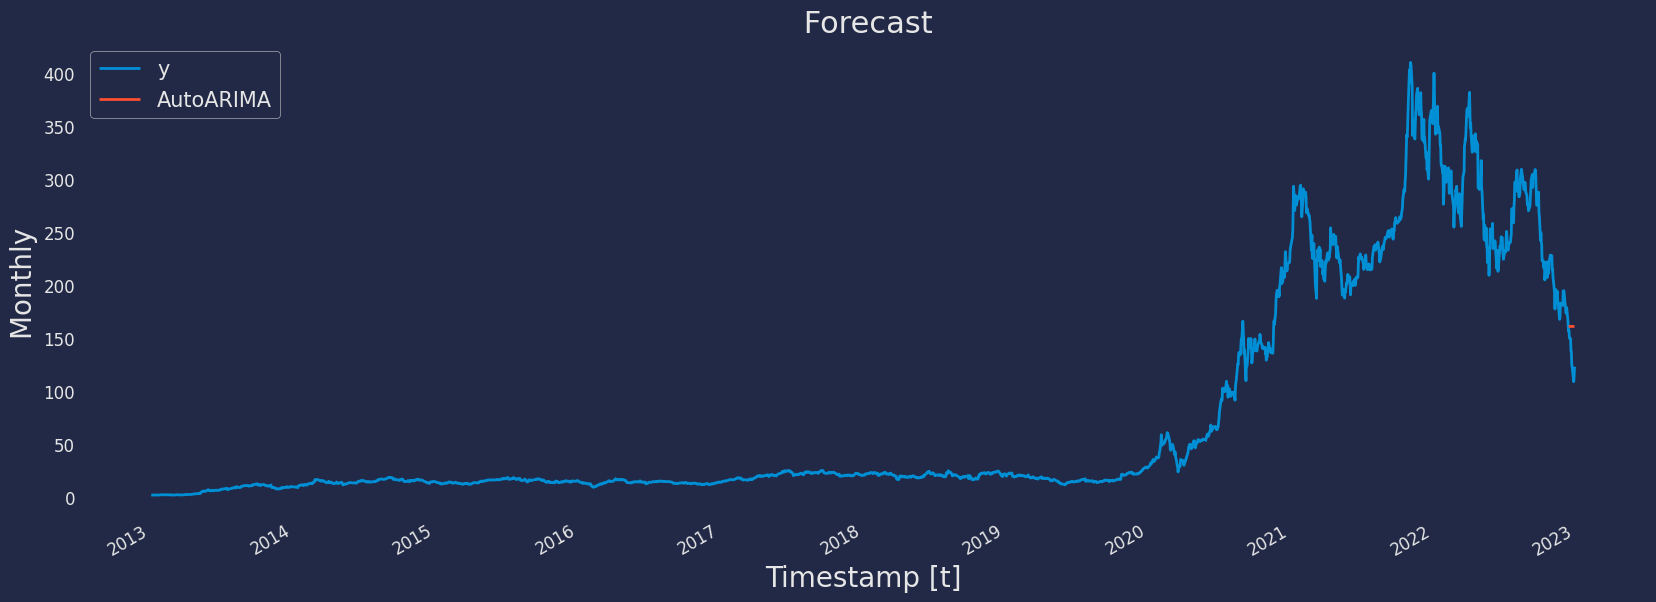

In [76]:
Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

#Predict method

In the following section we use the predict method and set a confidence interval. To use the predict method we need the arguemnts, the horizen, and the confidence level, which is the interval that the forecast will lay within

The following step includes the forecast horizon that we defined ealier:

In [77]:
sf.predict(h=12)

,ds,AutoARIMA
unique_id,,
1,2022-12-14,161.219528
1,2022-12-15,161.208954
1,2022-12-16,161.209366
1,2022-12-19,161.209351
1,2022-12-20,161.209351
1,2022-12-21,161.209351
1,2022-12-22,161.209351
1,2022-12-23,161.209351
1,2022-12-26,161.209351


We now want to make the same action but include the forecast using different confidence values.

Moreover we set the information into a new dataframe called "forecast_df":

In [78]:
forecast_df = sf.predict(h=12, level = [80, 95])

forecast_df

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
unique_id,,,,,,
1,2022-12-14,161.219528,151.586884,154.921082,167.517975,170.852173
1,2022-12-15,161.208954,147.850891,152.474594,169.943329,174.567017
1,2022-12-16,161.209366,144.950150,150.578033,171.840714,177.468597
1,2022-12-19,161.209351,142.493683,148.971832,173.446869,179.925018
1,2022-12-20,161.209351,140.324188,147.553268,174.865433,182.094528
1,2022-12-21,161.209351,138.359741,146.268799,176.149918,184.058960
1,2022-12-22,161.209351,136.551315,145.086334,177.332382,185.867401
1,2022-12-23,161.209351,134.866745,143.984848,178.433868,187.551971
1,2022-12-26,161.209351,133.283615,142.949692,179.469025,189.135101


In this section we want to combine the results from the forecast results and the historical data with the help of "pd.concat()":

In [79]:
df_plot=pd.concat([df, forecast_df]).set_index('ds').tail(220)
df_plot

,y,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,,,
2022-03-07,268.193329,1.0,NaN,NaN,NaN,NaN,NaN
2022-03-08,274.799988,1.0,NaN,NaN,NaN,NaN,NaN
2022-03-09,286.323334,1.0,NaN,NaN,NaN,NaN,NaN
2022-03-10,279.433319,1.0,NaN,NaN,NaN,NaN,NaN
2022-03-11,265.116669,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-12-23,NaN,NaN,161.209351,134.866745,143.984848,178.433868,187.551971
2022-12-26,NaN,NaN,161.209351,133.283615,142.949692,179.469025,189.135101
2022-12-27,NaN,NaN,161.209351,131.785538,141.970154,180.448563,190.633179


We now use the results from the above newly created forecast and historical data, including the confidence level of the forecast:

<ipython-input-80-2f1954e6d6e6>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_plot['AutoARIMA'], 'b-',  color="red", linewidth=2, label="AutoArima")


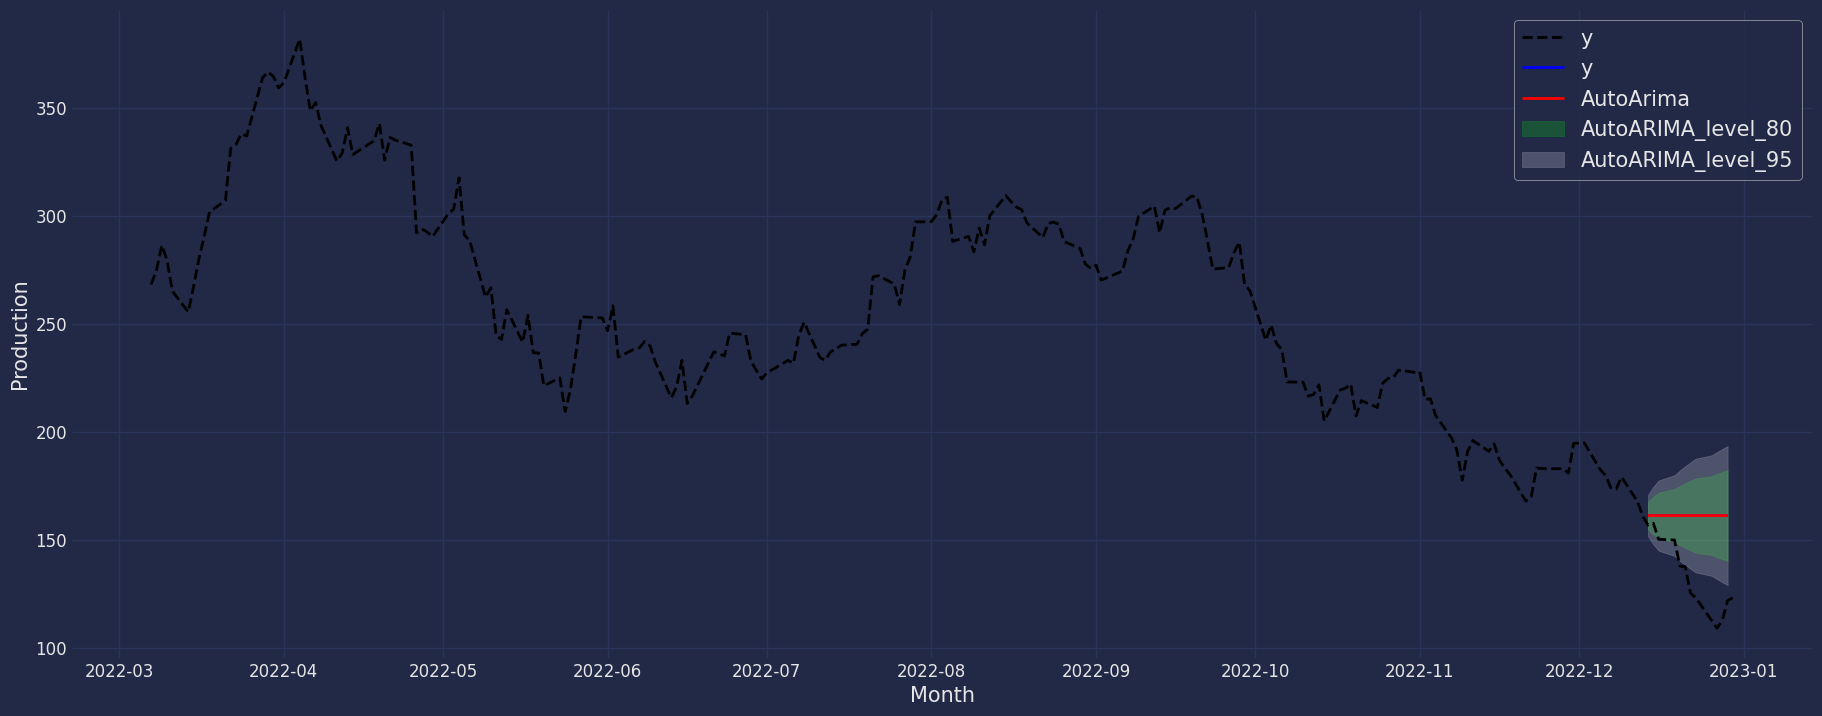

In [80]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

plt.plot(df_plot['y'], 'k--', df_plot['AutoARIMA'], 'b-', linewidth=2 ,label="y")
plt.plot(df_plot['AutoARIMA'], 'b-',  color="red", linewidth=2, label="AutoArima")

# Specify graph features:
ax.fill_between(df_plot.index,
                df_plot['AutoARIMA-lo-80'],
                df_plot['AutoARIMA-hi-80'],
                alpha=.20,
                color='lime',
                label='AutoARIMA_level_80')
ax.fill_between(df_plot.index,
                df_plot['AutoARIMA-lo-95'],
                df_plot['AutoARIMA-hi-95'],
                alpha=.2,
                color='white',
                label='AutoARIMA_level_95')
ax.set_title('', fontsize=20)
ax.set_ylabel('Production', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

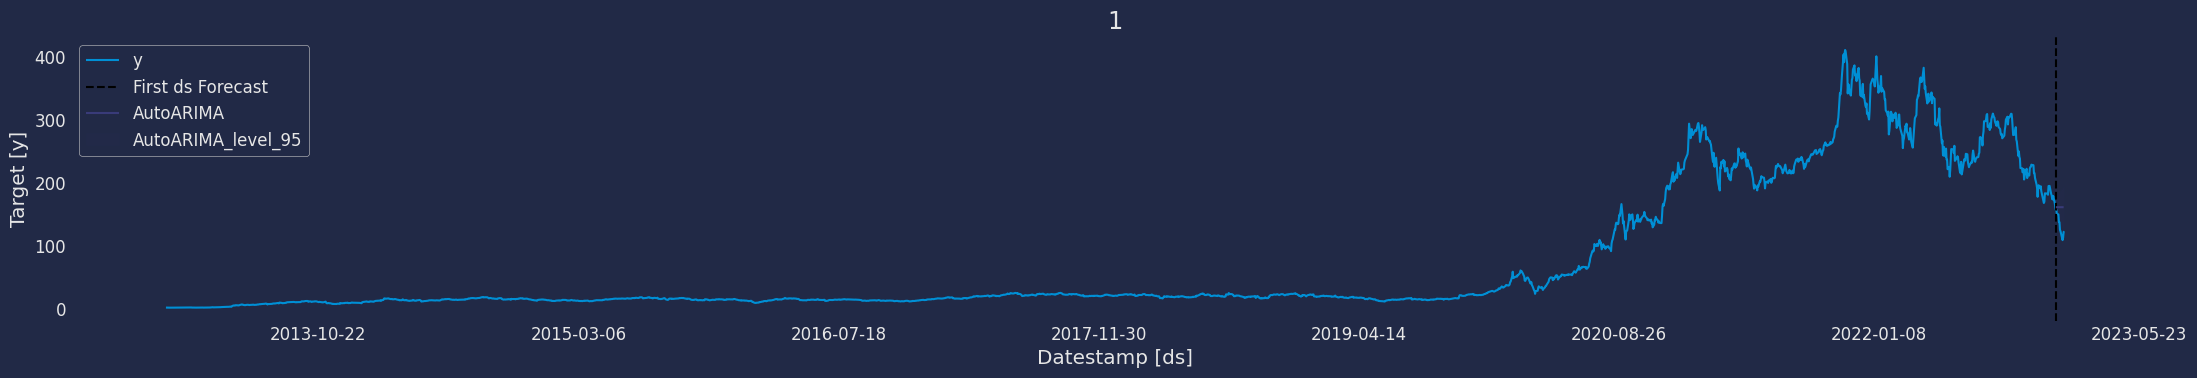

In [81]:
sf.plot(df, forecast_df, level=[95])

#Cross validation

We will now like to asses the accuray of the prediction we have made. This is done by performing cross-validation, given that this allso will give us an insight on have the model would have performed in the past

This is done be defining a slifing window across the data og prediction the period following it. This allow us to arrive at a better estimation of how good our model is to predict across a larger range, while still keeping th edata in the training set contiguous as is requried by our model

To do this procedure we use the cross_validation method from the NeuralForecast. To do this uptimal it is possible to use the following arguments: we have to define the dataframe, df, we can chose the step_size, which is the step size between each of the windows created, and the windows, n_window, whcih is the number of windows used in the cross validation

In [82]:
crossvalidation_df = sf.cross_validation(df=Y_train_df,
                                         h=12,
                                         step_size=1,
                                         n_windows=5)

By using the above we create a new dataframe which includes: the unique_id, the datastamp "ds", the "custoff" which is the last datastamp for the n number of window, and then the model result and the fitted values:

In [83]:
crossvalidation_df.head()

,ds,cutoff,y,AutoARIMA
unique_id,,,,
1,2022-11-22,2022-11-21,167.869995,180.311920
1,2022-11-23,2022-11-21,169.910004,180.306931
1,2022-11-24,2022-11-21,183.199997,180.307129
1,2022-11-25,2022-11-21,182.860001,180.307129
1,2022-11-28,2022-11-21,182.919998,180.307129


##Evaluation:

In the following section me compute the accuricy measurements of the model.

In [84]:
!pip install datasetsforecast

In [85]:
from datasetsforecast.losses import rmse

In [86]:
from datasetsforecast.losses import mae, mape, mase, rmse, smape

In [87]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  12.44034


In [88]:
mae = mae(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("Mae using cross-validation: ", mae)

Mae using cross-validation:  10.005939


In [89]:
mape = mape(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("Mape using cross-validation: ", mape)

Mape using cross-validation:  5.431617423892021


In [90]:
smape = smape(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("Smape using cross-validation: ", smape)

Smape using cross-validation:  5.570965260267258


We now use the results of our predictions using the predictions of the model

In [91]:
from datasetsforecast.losses import mae, mape, mase, rmse, smape

In [92]:
from datasetsforecast.evaluation import accuracy

In [93]:
def evaluate_performace(y_hist, y_true, model):
    evaluation = {}
    evaluation[model] = {}
    for metric in [mase, mae, mape, rmse, smape]:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[model][metric_name] = metric(y_true['y'].values,
                                                y_true[model].values,
                                                y_hist['y'].values, seasonality=12)
        else:
            evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [94]:
evaluate_performace(Y_train_df, Y_hat_df, model='AutoARIMA')

,mae,mape,mase,rmse,smape
AutoARIMA,26.476605,19.72904,NaN,31.249,17.034904
